In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('Hybrid_ESP.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_name          68 non-null     object 
 1   Cate_HOMO          68 non-null     float64
 2   Cate_LUMO          68 non-null     float64
 3   Cate_ESP_O1        68 non-null     float64
 4   Cate_ESP_H1        68 non-null     float64
 5   Cate_ESP_O2        68 non-null     float64
 6   Cate_ESP_H2        68 non-null     float64
 7   Cate_BL_ArO1       68 non-null     float64
 8   Cate_BL_O1H1       68 non-null     float64
 9   Cate_BL_ArO2       68 non-null     float64
 10  Cate_BL_O2H2       68 non-null     float64
 11  Cate_total_dipole  68 non-null     float64
 12  P_name             68 non-null     object 
 13  P_HOMO             68 non-null     float64
 14  P_LUMO             68 non-null     float64
 15  P_ESP_P            68 non-null     float64
 16  P_ESP_=O           68 non-nu

In [3]:
#Building descriptors
X = df.drop(columns=['Yield', 'Cate_name', 'P_name' ])
print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df['Yield'],columns=['Yield'])
y=y.astype(int)
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_HOMO  Cate_LUMO  Cate_ESP_O1  Cate_ESP_H1  Cate_ESP_O2  Cate_ESP_H2  \
0      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
1      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
2      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
3      -5.63       0.21    -0.555170     0.441278    -0.594799     0.444770   
4      -5.51       0.22    -0.542028     0.433177    -0.582447     0.440296   

   Cate_BL_ArO1  Cate_BL_O1H1  Cate_BL_ArO2  Cate_BL_O2H2  ...  rdkit_catePC1  \
0         1.363         0.969         1.378         0.965  ...      -5.580019   
1         1.363         0.969         1.378         0.965  ...      -5.580019   
2         1.363         0.969         1.378         0.965  ...      -5.580019   
3         1.363         0.969         1.378         0.965  ...      -5.580019   
4         1.364         0.969         1.379         0.965  ...      -2.835492   

   rdkit_catePC2  rd

In [4]:
print(X.info())
print(X.isnull().any())
print(X.isnull().values.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cate_HOMO          68 non-null     float64
 1   Cate_LUMO          68 non-null     float64
 2   Cate_ESP_O1        68 non-null     float64
 3   Cate_ESP_H1        68 non-null     float64
 4   Cate_ESP_O2        68 non-null     float64
 5   Cate_ESP_H2        68 non-null     float64
 6   Cate_BL_ArO1       68 non-null     float64
 7   Cate_BL_O1H1       68 non-null     float64
 8   Cate_BL_ArO2       68 non-null     float64
 9   Cate_BL_O2H2       68 non-null     float64
 10  Cate_total_dipole  68 non-null     float64
 11  P_HOMO             68 non-null     float64
 12  P_LUMO             68 non-null     float64
 13  P_ESP_P            68 non-null     float64
 14  P_ESP_=O           68 non-null     float64
 15  P_ESP_H            68 non-null     float64
 16  P_BL_P=O           68 non-nu

In [5]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_imp=pd.Series(index = X.columns)
cum_imp.fillna(0, inplace=True)

#RF
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    
    
    param_grid = {"max_depth":[2,3,4,5],
                  'n_estimators':[1000,3000,5000]}
    reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
    reg_rf.fit(a_X_train,y_train['Yield'])
    reg_best = reg_rf.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)
    y_pred2 = reg_best.predict(a_X_test)
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    parametors = reg_rf.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_rf.best_score_)
    
    #cumulative importances 
    importances = pd.Series(reg_best.feature_importances_, index = X.columns)
    cum_imp += importances
    
    print('----------------------')
    print('seed:', seed)
    print("Best Model Parameter:",reg_rf.best_params_)
    print("Best Model Score:",reg_rf.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


----------------------
seed: 0
Best Model Parameter: {'max_depth': 2, 'n_estimators': 3000}
Best Model Score: 0.8003781435672895
R2_test: 0.7191639467708719
----------------------
seed: 1
Best Model Parameter: {'max_depth': 3, 'n_estimators': 3000}
Best Model Score: 0.6973818514878842
R2_test: 0.8462691033799473
----------------------
seed: 2
Best Model Parameter: {'max_depth': 2, 'n_estimators': 5000}
Best Model Score: 0.7593943514929608
R2_test: 0.7928426012181254
----------------------
seed: 3
Best Model Parameter: {'max_depth': 2, 'n_estimators': 3000}
Best Model Score: 0.760308896259968
R2_test: 0.745757458200358
----------------------
seed: 4
Best Model Parameter: {'max_depth': 2, 'n_estimators': 1000}
Best Model Score: 0.8091984182496246
R2_test: 0.7715946154437981
----------------------
seed: 5
Best Model Parameter: {'max_depth': 4, 'n_estimators': 1000}
Best Model Score: 0.7855043281229849
R2_test: 0.799543832206101
----------------------
seed: 6
Best Model Parameter: {'max_de

In [6]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['RMSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])

data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, 
                      data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd],
                     axis=1, join='inner')

data_all.loc['mean'] = data_all.mean()
print(data_all)

data_all.to_csv('../../score/Hybrid/RF_score.csv')
#data_parametors.to_csv('/Users/nata/Documents/ML/amidation/score/Hybrid/Hybrid_ESP/RF/parametors.csv')

      r2_train  RMSE_train  MAE_train   r2_test   RMSE_test   MAE_test  \
0     0.905833   69.425922   5.329931  0.719164  367.319548  11.984728   
1     0.917640   74.479173   5.371572  0.846269  148.941883   7.975489   
2     0.878719  112.196672   6.555225  0.792843  200.333888   8.458854   
3     0.888942  103.584773   6.132895  0.745757  244.008271   9.335651   
4     0.890855   94.093595   5.881533  0.771595  242.868987  10.743983   
5     0.951290   39.442051   3.569552  0.799544  243.795609  10.240983   
6     0.882706   96.259966   6.149433  0.775072  270.692180  10.094685   
7     0.890660  104.583584   6.443739  0.741008  234.777976   9.671395   
8     0.875948  109.179832   5.913413  0.760863  236.323352  10.866931   
9     0.855591  146.350459   7.821490  0.884494   81.392298   5.975114   
mean  0.893819   94.959603   5.916878  0.783661  227.045399   9.534781   

      cv_score  
0     0.800378  
1     0.697382  
2     0.759394  
3     0.760309  
4     0.809198  
5     0.7

In [10]:
seed=9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)

    
param_grid = {"max_depth":[2,3,4,5],'n_estimators':[1000,3000,5000]}
reg_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid, cv=5, n_jobs=3)
reg_rf.fit(a_X_train,y_train['Yield'])
reg_best = reg_rf.best_estimator_
y_pred1 = reg_best.predict(a_X_train)
y_pred2 = reg_best.predict(a_X_test)
            
r2_train = metrics.r2_score(y_train, y_pred1)
r2_test = metrics.r2_score(y_test, y_pred2)
print('r2_train:',r2_train)
print('r2_test:',r2_test)

r2_train: 0.8555908598143708
r2_test: 0.8844938332613719


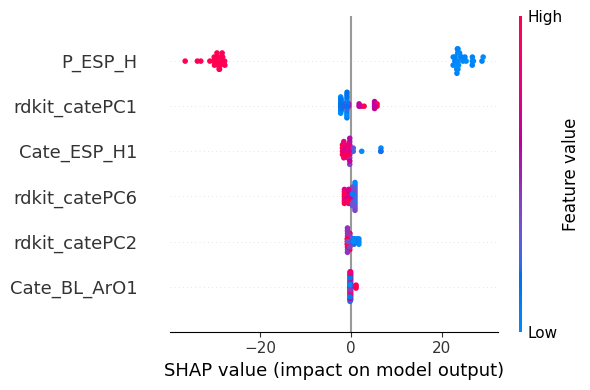

In [11]:
#shap
explainer = shap.TreeExplainer(reg_best)
shap_values = explainer.shap_values(X=a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=6, plot_size=(6,4))